In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/movielens1m/users.dat
/kaggle/input/movielens1m/ratings.dat
/kaggle/input/movielens1m/movies.dat


In [2]:
!pip install surprise lightfm tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp311-cp311-linux_x86_64.whl size=831166 sha256=6ec6b7c8583bfe6211d8a22cd72d221b404d815ae2908e9917ad3db0a0a1e5f4
  Stored in directory: /root/.cache/pip/wheels/b9/0d/8a/0729d2e6e3ca2a898ba55201f905da7db3f838a33df5b3fcdd
Successfully built lightfm


In [3]:
import pandas as pd, numpy as np
import surprise, lightfm, tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
ratings = pd.read_csv('/kaggle/input/movielens1m/ratings.dat', 
                      delimiter='::', engine='python', header=None, names = ['UserID', 'MovieID', 'Rating', 'Timestamp'])

users = pd.read_csv('/kaggle/input/movielens1m/users.dat', 
                    delimiter='::', engine='python', header=None)

movies = pd.read_csv('/kaggle/input/movielens1m/movies.dat', 
                     delimiter='::', engine='python', header=None, 
                     names=['MovieID', 'Title', 'Genres'],
                     encoding='latin-1')  


In [5]:
users.columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']


In [6]:
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [7]:
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [9]:
print("Ratings shape:",ratings.shape)
print("Users shape:",users.shape)
print("Movies shape",movies.shape)

Ratings shape: (1000209, 4)
Users shape: (6040, 5)
Movies shape (3883, 3)


In [10]:
n_users = ratings['UserID'].nunique()
n_movies = ratings['MovieID'].nunique()

print("Unique users:",n_users)
print("Unique movies:",n_movies)
print("Total ratings:",ratings.shape[0])

Unique users: 6040
Unique movies: 3706
Total ratings: 1000209


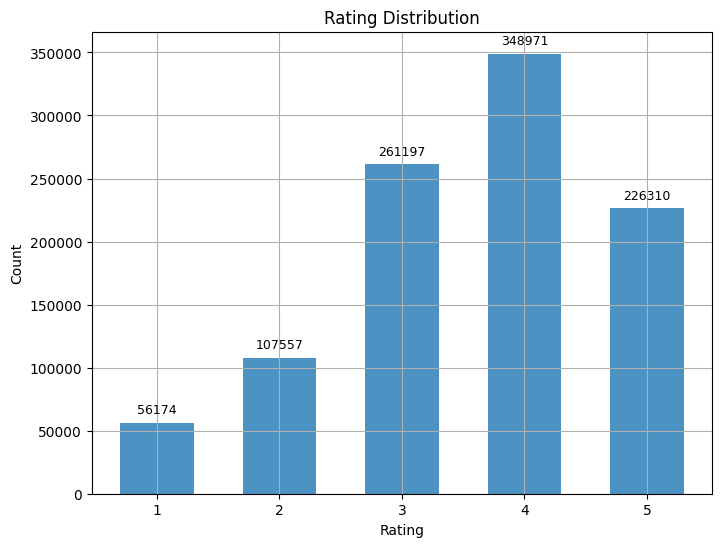

In [11]:
# Count ratings
rating_counts = ratings['Rating'].value_counts().sort_index()

# Plot histogram
plt.figure(figsize=(8, 6))
bars = plt.bar(rating_counts.index, rating_counts.values, width=0.6, alpha=0.8)

# Add count labels
for i, (x, y) in enumerate(zip(rating_counts.index, rating_counts.values)):
    plt.text(x, y + 5000, str(y), ha='center', va='bottom', fontsize=9)

# Aesthetics
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.grid(True)
plt.xticks(rating_counts.index)  # ensure ticks are only 1 to 5

plt.show()

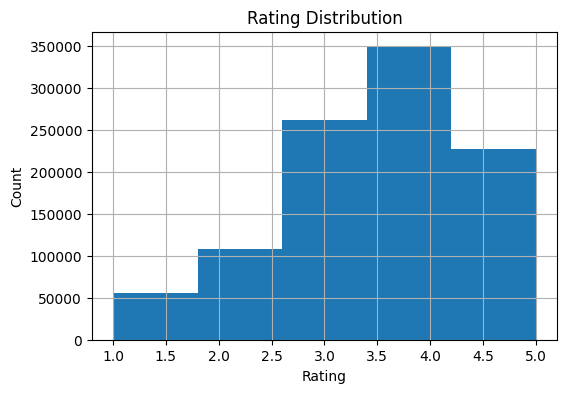

Mean rating: 3.581564453029317
Median rating: 4.0
Mode rating: 4


In [12]:
plt.figure(figsize=(6,4))
ratings['Rating'].hist(bins=5)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

print("Mean rating:", ratings['Rating'].mean())
print("Median rating:", ratings['Rating'].median())
print("Mode rating:", ratings['Rating'].mode()[0])


the data is skewed towards the right side.

In [13]:
ratings['Rating'].describe()

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [14]:

print(users['Gender'].value_counts())

print(users['Age'].value_counts().sort_index())


Gender
M    4331
F    1709
Name: count, dtype: int64
Age
1      222
18    1103
25    2096
35    1193
45     550
50     496
56     380
Name: count, dtype: int64


In [15]:
# Inspect columns and first few rows
print(users.columns)



Index(['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], dtype='object')


Genres
Drama         1603
Comedy        1200
Action         503
Thriller       492
Romance        471
Horror         343
Adventure      283
Sci-Fi         276
Children's     251
Crime          211
Name: count, dtype: int64


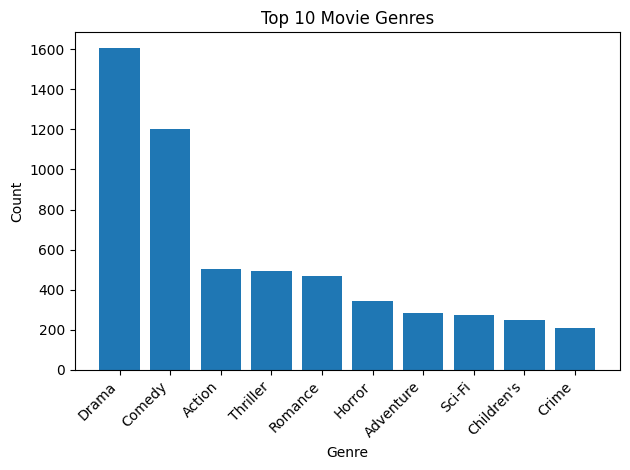

In [16]:

# Explode genres into one-row-per-genre
genre_series = movies['Genres'].str.split('|').explode()
genre_counts = genre_series.value_counts()

# Show top 10 genres
print(genre_counts.head(10))

top_genres = genre_counts.head(10)

plt.figure()
plt.bar(top_genres.index, top_genres.values)
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Movie Genres")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


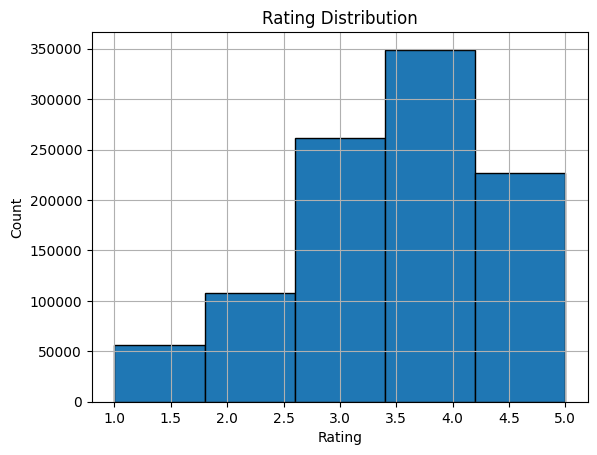

In [17]:
ratings['Rating'].hist(bins=5, edgecolor='black')
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


/tmp/ipykernel_13/2774340333.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ratings.resample('M')['Rating'].count().plot()


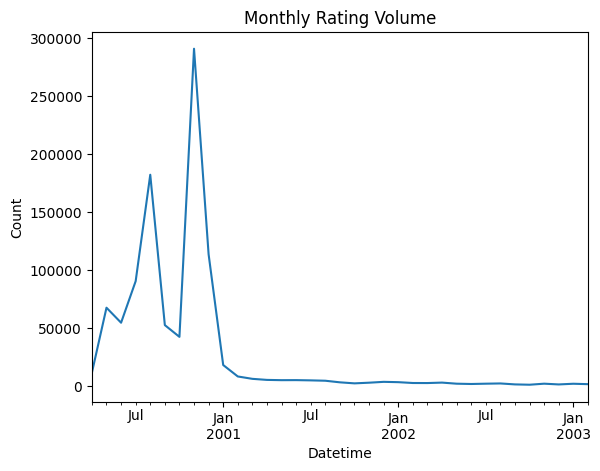

()

In [18]:
# Convert to datetime
ratings['Datetime'] = pd.to_datetime(ratings['Timestamp'], unit='s')
ratings.set_index('Datetime', inplace=True)

# Plot ratings over time (e.g. monthly)
ratings.resample('M')['Rating'].count().plot()
plt.title("Monthly Rating Volume")
plt.ylabel("Count"); plt.show()
/

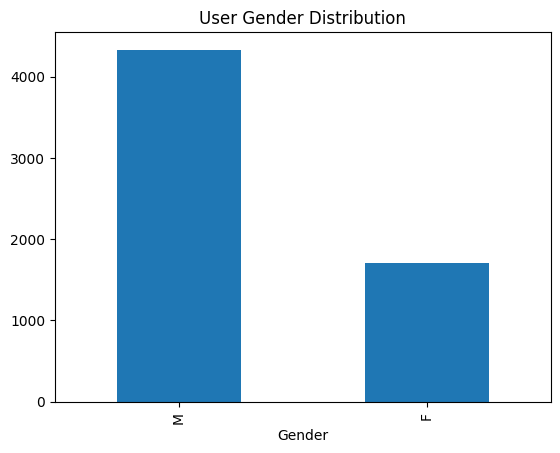

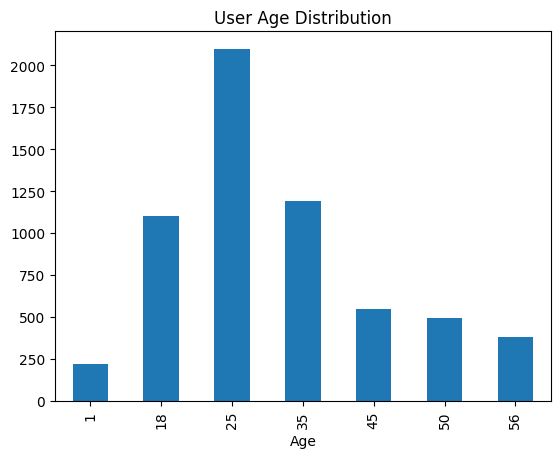

In [19]:
# Gender
users['Gender'].value_counts().plot(kind='bar')
plt.title("User Gender Distribution"); plt.show()

# Age groups
users['Age'].value_counts().sort_index().plot(kind='bar')
plt.title("User Age Distribution"); plt.show()


In [20]:

ratings_users = pd.merge(ratings, users, on='UserID', how='left')

full = pd.merge(ratings_users, movies, on='MovieID', how='left')
full.head()


,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Title,Genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,978302109,F,1,10,48067,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,978301968,F,1,10,48067,My Fair Lady (1964),Musical|Romance
3,1,3408,4,978300275,F,1,10,48067,Erin Brockovich (2000),Drama
4,1,2355,5,978824291,F,1,10,48067,"Bug's Life, A (1998)",Animation|Children's|Comedy


In [21]:
# Split genres and explode rows
full['GenreList'] = full['Genres'].str.split('|')
full_exploded = full.explode('GenreList')
full_exploded.head()


,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Title,Genres,GenreList
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama,Drama
1,1,661,3,978302109,F,1,10,48067,James and the Giant Peach (1996),Animation|Children's|Musical,Animation
1,1,661,3,978302109,F,1,10,48067,James and the Giant Peach (1996),Animation|Children's|Musical,Children's
1,1,661,3,978302109,F,1,10,48067,James and the Giant Peach (1996),Animation|Children's|Musical,Musical
2,1,914,3,978301968,F,1,10,48067,My Fair Lady (1964),Musical|Romance,Musical


In [22]:
# Group by gender and genre, count ratings
genre_gender_counts = full_exploded.groupby(['GenreList', 'Gender']).size().reset_index(name='count')
genre_gender_counts = genre_gender_counts.pivot(index='GenreList', columns='Gender', values='count').fillna(0)
genre_gender_counts.head()


Gender,F,M
GenreList,,
Action,45650,211807
Adventure,27332,106621
Animation,12221,31072
Children's,21317,50869
Comedy,96271,260309


In [23]:
num_males = users[users['Gender'] == 'M'].shape[0]
num_females = users[users['Gender'] == 'F'].shape[0]

# Normalize: ratings per genre per gender divided by total users of that gender
genre_gender_counts['per_male_user'] = genre_gender_counts['M'] / num_males
genre_gender_counts['per_female_user'] = genre_gender_counts['F'] / num_females


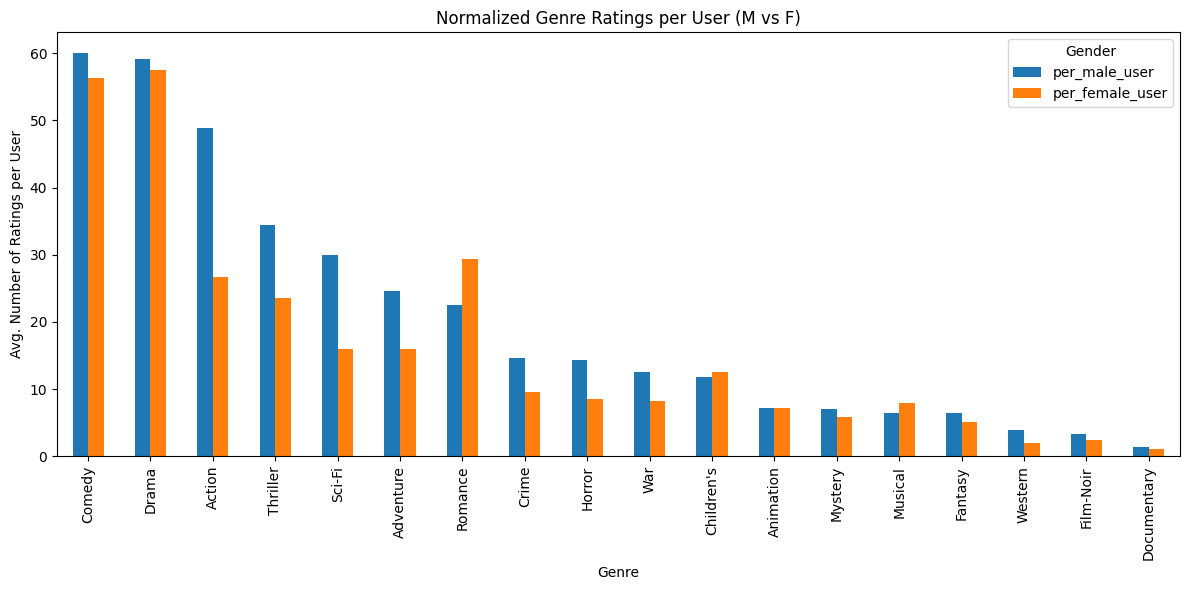

In [24]:
# Sort by highest per-male-user rating count
genre_gender_counts_sorted = genre_gender_counts.sort_values('per_male_user', ascending=False)

# Plot
genre_gender_counts_sorted[['per_male_user', 'per_female_user']].plot(kind='bar', figsize=(12,6))
plt.title('Normalized Genre Ratings per User (M vs F)')
plt.ylabel('Avg. Number of Ratings per User')
plt.xlabel('Genre')
plt.tight_layout()
plt.show()


Genre Preferences: Both males and females most commonly rate Comedy and Drama. Males have a stronger tendency to rate Action, Thriller, and Sci-Fi, while females lean slightly more toward Romance per user.

User Demographics: The largest age group is 25–35, meaning most ratings come from young adults. Older and younger users are underrepresented.

Temporal Patterns: The majority of ratings are concentrated in a specific window (late 2000–early 2001). This temporal concentration might influence user similarity and popularity metrics.

Rating Distribution: The dataset is skewed toward positive ratings (3 and above), with relatively few low ratings. This suggests most users tend to rate movies they like.



# **Data Preprocessing and feature engineering**

In [25]:
# Make a copy to avoid modifying original
movies_features = movies.copy()

# Split genres and use MultiLabelBinarizer for one-hot encoding
from sklearn.preprocessing import MultiLabelBinarizer

movies_features['GenreList'] = movies_features['Genres'].str.split('|')
mlb = MultiLabelBinarizer()
genre_ohe = mlb.fit_transform(movies_features['GenreList'])

# Add one-hot columns to DataFrame
genre_df = pd.DataFrame(genre_ohe, columns=mlb.classes_, index=movies_features.index)
movies_features = pd.concat([movies_features, genre_df], axis=1)

movies_features.head()


,MovieID,Title,Genres,GenreList,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Animation|Children's|Comedy,"[Animation, Children's, Comedy]",0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,"[Adventure, Children's, Fantasy]",0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]",0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama,"[Comedy, Drama]",0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,[Comedy],0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
import re

# Extract year from the Title (e.g. "Toy Story (1995)")
movies_features['Year'] = movies_features['Title'].str.extract(r'\((\d{4})\)')
movies_features['Year'] = movies_features['Year'].astype(float)
movies_features.head()


,MovieID,Title,Genres,GenreList,Action,Adventure,Animation,Children's,Comedy,Crime,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Year
0,1,Toy Story (1995),Animation|Children's|Comedy,"[Animation, Children's, Comedy]",0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1995.0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,"[Adventure, Children's, Fantasy]",0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1995.0
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]",0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1995.0
3,4,Waiting to Exhale (1995),Comedy|Drama,"[Comedy, Drama]",0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1995.0
4,5,Father of the Bride Part II (1995),Comedy,[Comedy],0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1995.0


In [27]:
# Merge ratings with one-hot encoded genres and year
ratings_with_features = ratings.merge(movies_features[['MovieID'] + list(mlb.classes_) + ['Year']], 
                                      on='MovieID', how='left')
ratings_with_features.head()


,UserID,MovieID,Rating,Timestamp,Action,Adventure,Animation,Children's,Comedy,Crime,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Year
0,1,1193,5,978300760,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1975.0
1,1,661,3,978302109,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,1996.0
2,1,914,3,978301968,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1964.0
3,1,3408,4,978300275,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2000.0
4,1,2355,5,978824291,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1998.0


In [28]:
# Filter for highly rated movies (e.g., 4 or 5 stars)
high_ratings = ratings_with_features[ratings_with_features['Rating'] >= 4]

# Group by user and compute average genre vector
user_profiles = high_ratings.groupby('UserID')[mlb.classes_].mean()
user_profiles.head()


,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
UserID,,,,,,,,,,,,,,,,,,
1,0.088889,0.088889,0.311111,0.400000,0.244444,0.044444,0.00000,0.466667,0.066667,0.000000,0.000000,0.266667,0.000000,0.066667,0.066667,0.044444,0.044444,0.000000
2,0.356164,0.150685,0.000000,0.000000,0.191781,0.082192,0.00000,0.712329,0.000000,0.013699,0.000000,0.000000,0.013699,0.178082,0.109589,0.205479,0.109589,0.041096
3,0.486486,0.567568,0.054054,0.054054,0.513514,0.000000,0.00000,0.189189,0.054054,0.000000,0.027027,0.027027,0.000000,0.108108,0.108108,0.081081,0.054054,0.162162
4,0.888889,0.222222,0.000000,0.055556,0.000000,0.055556,0.00000,0.277778,0.111111,0.000000,0.166667,0.000000,0.000000,0.055556,0.333333,0.166667,0.055556,0.111111
5,0.097561,0.060976,0.036585,0.048780,0.353659,0.121951,0.04878,0.512195,0.000000,0.024390,0.024390,0.024390,0.024390,0.109756,0.073171,0.158537,0.048780,0.012195


In [29]:
# Save processed features for later use
movies_features.to_csv('movies_features.csv', index=False)
ratings_with_features.to_csv('ratings_with_features.csv', index=False)
user_profiles.to_csv('user_profiles.csv')


In [30]:
!pip install wikipedia


  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=05ee9c8d5571b92c2d8d55855a6c29e9ddf4b95e2779a1704322a8d57cb8c29b
  Stored in directory: /root/.cache/pip/wheels/8f/ab/cb/45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
Successfully built wikipedia


In [31]:
import wikipedia
import re
from tqdm.notebook import tqdm


In [32]:
def get_wikipedia_page_name(raw_name):
    try:
        names = wikipedia.search(raw_name)
        if len(names) == 0:
            return ''
        else:
            return names[0]
    except Exception:
        return ''


In [33]:
def get_movie_plot(page_name):
    try:
        try:
            movie_page_content = str(wikipedia.page(page_name, auto_suggest=False).content)
        except wikipedia.DisambiguationError as e:
            for option in e.options:
                if 'film' in option.lower():
                    movie_page_content = str(wikipedia.page(option, auto_suggest=False).content)
                    break
            else:
                return ''
        except (wikipedia.PageError, KeyError):
            return ''
        # Try to extract the "Plot" section with various patterns
        match = re.search(r"==\s*Plot\s*==(.+?)(==|$)", movie_page_content, re.DOTALL)
        if match:
            return match.group(1).strip()
        else:
            # If no plot section, return the first 500 characters of the page as a fallback
            return movie_page_content[:500]
    except Exception:
        return ''


In [34]:
# We use 'Title' as the movie title column (from movies_features)
tqdm.pandas()  # for progress bar

movies_features['wikipedia_page_name'] = movies_features['Title'].progress_apply(get_wikipedia_page_name)


  0%|          | 0/3883 [00:00<?, ?it/s]

In [35]:
movies_features['movie_plot'] = movies_features['wikipedia_page_name'].progress_apply(get_movie_plot)


  0%|          | 0/3883 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.11/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [36]:
print(f'There are {movies_features["movie_plot"].isna().sum()} NaN movie plots')
movies_features[['Title', 'movie_plot']].head()


There are 0 NaN movie plots


,Title,movie_plot
0,Toy Story (1995),"A group of sentient toys, who pretend to be li..."
1,Jumanji (1995),"In 1969, Alan Parrish lives in Brantford, New ..."
2,Grumpier Old Men (1995),The feud between Max and John has cooled and t...
3,Waiting to Exhale (1995),"Four friends (Savannah, Robin, Bernadine, and ..."
4,Father of the Bride Part II (1995),"Four years after the events of the first film,..."


In [37]:
# Remove movies without plot summaries (empty string or NaN)
movies_with_plots = movies_features[movies_features['movie_plot'].notna() & (movies_features['movie_plot'] != '')]
movie_ids_with_plots = set(movies_with_plots['MovieID'])

# Filter ratings accordingly (assuming you merged features into ratings_with_features)
ratings_with_plots = ratings_with_features[ratings_with_features['MovieID'].isin(movie_ids_with_plots)]

print("Movies with plot summaries:", len(movies_with_plots))
print("Ratings with plots:", len(ratings_with_plots))


Movies with plot summaries: 3829
Ratings with plots: 992665


Data Exploration:

Loaded and inspected the MovieLens 1M dataset, including user, movie, and ratings tables.

Analyzed dataset statistics: number of unique users (6,040), movies (approximately 3,900), and ratings (over 1 million).

Explored distributions of ratings, user activity, movie popularity, age groups, and gender.

Visualized key characteristics such as the skewed positive rating distribution, the concentration of ratings by age group, and genre preferences across demographic segments.

Feature Engineering:

Genre One-Hot Encoding: Transformed the Genres field from a pipe-separated string (e.g., "Action|Comedy") into a binary vector for each genre, enabling models to recognize and utilize genre information for each movie.

Year Extraction: Parsed the movie release year from the movie title, creating a new Year feature for temporal analysis and potential modeling.

Wikipedia Plot Summaries: Integrated an external data source by programmatically retrieving movie plot summaries from Wikipedia for each movie, laying the groundwork for advanced content-based recommendations. Movies without available plot summaries (due to missing Wikipedia information) and their associated ratings were subsequently removed to maintain dataset consistency.